<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Importing and separating the xGASS dataset

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

In [ ]:
# Reading the crossmatched data into the code
# This table is crossmatched from the xGASS representative sample from Catinella et al 2018 and the xGASS decomposition master table from Cook et al 2019
hdulist = fits.open('xGASS_repDecomp_sample.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
# Importing data into arrays
HI_FLAG0 = hdu['HI_FLAG']
HIsrc0 = hdu['HIsrc']
GASS0 = hdu['GASS']
RA0 = hdu['RA_1']
DEC0 = hdu['DEC_1']
zSDSS0 = hdu['zSDSS_1']
Dlum0 = hdu['Dlum']
lgMstar0 = hdu['lgMstar']
petro90r0 = hdu['petrR90_r']
petro50r0 = hdu['petrR50_r']
lgmust0 = hdu['lgmust']
NUVr0 = hdu['NUVr']
lgSFR_tot_median0 = hdu['lgSFR_tot_median']
SFR_best0 = hdu['SFR_best']
lgMHI0 = hdu['lgMHI']
lgGF0 = hdu['lgGF']
reD_r0 = hdu['reD_r']
MFlag0 = hdu['ModelFlag']
BtoMCorr0 = hdu['B2T_M']
print('Starting length of the dataset is', len(HI_FLAG0))

Starting length of the dataset is 1179


In [ ]:
# The first cut of the data is to remove the galaxies where there is no recorded effective radius of the disk
HI_FLAG_nan = np.delete(HI_FLAG0, (np.where(np.isnan(reD_r0))[0]))
HIsrc_nan = np.delete(HIsrc0, (np.where(np.isnan(reD_r0))[0]))
GASS_nan = np.delete(GASS0, (np.where(np.isnan(reD_r0))[0]))
zSDSS_nan = np.delete(zSDSS0, (np.where(np.isnan(reD_r0))[0]))
Dlum_nan = np.delete(Dlum0, (np.where(np.isnan(reD_r0))[0]))
lgMstar_nan = np.delete(lgMstar0, (np.where(np.isnan(reD_r0))[0]))
petro90r_nan = np.delete(petro90r0, (np.where(np.isnan(reD_r0))[0]))
petro50r_nan = np.delete(petro50r0, (np.where(np.isnan(reD_r0))[0]))
lgmust_nan = np.delete(lgmust0, (np.where(np.isnan(reD_r0))[0]))
NUVr_nan = np.delete(NUVr0, (np.where(np.isnan(reD_r0))[0]))
lgSFR_tot_median_nan = np.delete(lgSFR_tot_median0, (np.where(np.isnan(reD_r0))[0]))
SFR_best_nan = np.delete(SFR_best0, (np.where(np.isnan(reD_r0))[0]))
lgMHI_nan = np.delete(lgMHI0, (np.where(np.isnan(reD_r0))[0]))
lgGF_nan = np.delete(lgGF0, (np.where(np.isnan(reD_r0))[0]))
reD_r_nan = np.delete(reD_r0, (np.where(np.isnan(reD_r0))[0]))
MFlag_nan = np.delete(MFlag0, (np.where(np.isnan(reD_r0))[0]))
BtoMCorr_nan = np.delete(BtoMCorr0, (np.where(np.isnan(reD_r0))[0]))
print('Galaxies where there is no recorded effective radius of the disk:', len(np.where(np.isnan(reD_r0))[0]))
print('Number of galaxies present in the dataset:', len(HI_FLAG_nan))

Galaxies where there is no recorded effective radius of the disk: 161
Number of galaxies present in the dataset: 1018


In [ ]:
# A HI flag determines whether a galaxy is fully resolved, marginally resolved or confused, this cut will remove all galaxies that are marginally confused and confused from the data
GASS_conf = np.delete(GASS_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
zSDSS_conf = np.delete(zSDSS_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
Dlum_conf = np.delete(Dlum_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
lgMstar_conf = np.delete(lgMstar_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
petro90r_conf = np.delete(petro90r_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
petro50r_conf = np.delete(petro50r_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
lgmust_conf = np.delete(lgmust_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
NUVr_conf = np.delete(NUVr_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
lgSFR_tot_median_conf = np.delete(lgSFR_tot_median_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
SFR_best_conf = np.delete(SFR_best_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
lgMHI_conf = np.delete(lgMHI_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
lgGF_conf = np.delete(lgGF_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
HI_FLAG_conf = np.delete(HI_FLAG_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
HIsrc_conf = np.delete(HIsrc_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
reD_r_conf = np.delete(reD_r_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
MFlag_conf = np.delete(MFlag_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
BtoMCorr_conf = np.delete(BtoMCorr_nan, np.where((HI_FLAG_nan > 1) & (HI_FLAG_nan < 90)))
print('Number of galaxies that are marginally or fully confused:', len(np.where((HI_FLAG0 > 1) & (HI_FLAG0 < 90))[0]))
print('Number of galaxies removed by this cut:', len(HI_FLAG_nan) - len(HI_FLAG_conf))
print('Number of galaxies present in the dataset:', len(HI_FLAG_conf))

Number of galaxies that are marginally or fully confused: 113
Number of galaxies removed by this cut: 86
Number of galaxies present in the dataset: 932


In [ ]:
# Removing any galaxies that remain without defined NUV-r values
GASS_nuv = np.delete(GASS_conf, np.where((NUVr_conf < 0)))
zSDSS_nuv = np.delete(zSDSS_conf, np.where((NUVr_conf < 0)))
Dlum_nuv = np.delete(Dlum_conf, np.where((NUVr_conf < 0)))
lgMstar_nuv = np.delete(lgMstar_conf, np.where((NUVr_conf < 0)))
petro90r_nuv = np.delete(petro90r_conf, np.where((NUVr_conf < 0)))
petro50r_nuv = np.delete(petro50r_conf, np.where((NUVr_conf < 0)))
lgmust_nuv = np.delete(lgmust_conf, np.where((NUVr_conf < 0)))
NUVr_nuv = np.delete(NUVr_conf, np.where((NUVr_conf < 0)))
lgSFR_tot_median_nuv = np.delete(lgSFR_tot_median_conf, np.where((NUVr_conf < 0)))
SFR_best_nuv = np.delete(SFR_best_conf, np.where((NUVr_conf < 0)))
lgMHI_nuv = np.delete(lgMHI_conf, np.where((NUVr_conf < 0)))
lgGF_nuv = np.delete(lgGF_conf, np.where((NUVr_conf < 0)))
HI_FLAG_nuv = np.delete(HI_FLAG_conf, np.where((NUVr_conf < 0)))
HIsrc_nuv = np.delete(HIsrc_conf, np.where((NUVr_conf < 0)))
reD_r_nuv = np.delete(reD_r_conf, np.where((NUVr_conf < 0)))
MFlag_nuv = np.delete(MFlag_conf, np.where((NUVr_conf < 0)))
BtoMCorr_nuv = np.delete(BtoMCorr_conf, np.where((NUVr_conf < 0)))
print('Number of galaxies now present in the dataset:', len(HI_FLAG_nuv))

Number of galaxies now present in the dataset: 918


In [ ]:
# Removing any galaxies that remain without defined SFR values
GASS = np.delete(GASS_nuv, np.where((SFR_best_nuv < 0)))
zSDSS = np.delete(zSDSS_nuv, np.where((SFR_best_nuv < 0)))
Dlum = np.delete(Dlum_nuv, np.where((SFR_best_nuv < 0)))
lgMstar = np.delete(lgMstar_nuv, np.where((SFR_best_nuv < 0)))
petro90r = np.delete(petro90r_nuv, np.where((SFR_best_nuv < 0)))
petro50r = np.delete(petro50r_nuv, np.where((SFR_best_nuv < 0)))
lgmust = np.delete(lgmust_nuv, np.where((SFR_best_nuv < 0)))
NUVr = np.delete(NUVr_nuv, np.where((SFR_best_nuv < 0)))
lgSFR_tot_median = np.delete(lgSFR_tot_median_nuv, np.where((SFR_best_nuv < 0)))
SFR_best = np.delete(SFR_best_nuv, np.where((SFR_best_nuv < 0)))
lgMHI = np.delete(lgMHI_nuv, np.where((SFR_best_nuv < 0)))
lgGF = np.delete(lgGF_nuv, np.where((SFR_best_nuv < 0)))
HI_FLAG = np.delete(HI_FLAG_nuv, np.where((SFR_best_nuv < 0)))
HIsrc = np.delete(HIsrc_nuv, np.where((SFR_best_nuv < 0)))
reD_r = np.delete(reD_r_nuv, np.where((SFR_best_nuv < 0)))
MFlag = np.delete(MFlag_nuv, np.where((SFR_best_nuv < 0)))
BtoMCorr = np.delete(BtoMCorr_nuv, np.where((SFR_best_nuv < 0)))
print('Number of galaxies now present in the dataset:', len(HI_FLAG))

Number of galaxies now present in the dataset: 912


In [ ]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
# Subtracting no HI detection
# All HI-detected galaxy properties below
HIndet = np.where(HIsrc >= 4)[0]

zSDSS1 = np.delete(zSDSS, (HIndet))
Dlum1 = np.delete(Dlum, (HIndet))
lgMstar1 = np.delete(lgMstar, (HIndet))
petro90r1 = np.delete(petro90r, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
lgSFR1 = np.log10(SFR_best1)
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

# Subtracting HI detection
# All no-HI-detected galaxies below
HIdet = np.where(HIsrc < 4)[0]

zSDSS2 = np.delete(zSDSS, (HIdet))
Dlum2 = np.delete(Dlum, (HIdet))
lgMstar2 = np.delete(lgMstar, (HIdet))
petro90r2 = np.delete(petro90r, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

# The bottom two prints should sum to the top print statement
print(len(lgMstar))
print(len(lgMstar1))
print(len(lgMstar2))

912
619
293


2) Plotting the global HI mass for each galaxy

In [ ]:
# Finding the running median of the HI detections
# Arrays for the bins
bins_HIgl_Mstar = np.linspace(9, 11.9, 10)
bins_HIgl_SFR = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
median_HIgl_Mstar = np.zeros(len(bins_HIgl_Mstar))
MAD_HIgl_Mstar = np.zeros(len(bins_HIgl_Mstar))

median_HIgl_SFR = np.zeros(len(bins_HIgl_SFR))
MAD_HIgl_SFR = np.zeros(len(bins_HIgl_SFR))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_HIgl_Mstar) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median_HIgl_Mstar[i] = np.median(lgMHI1[np.where((lgMstar1 >= bins_HIgl_Mstar[i]) & (lgMstar1 <= bins_HIgl_Mstar[i+1]))])
  MAD_HIgl_Mstar[i] = stats.median_abs_deviation(lgMHI1[np.where((lgMstar1 >= bins_HIgl_Mstar[i]) & (lgMstar1 <= bins_HIgl_Mstar[i+1]))])

  # Median and MAD for HI of galaxies against SFR
  median_HIgl_SFR[i] = np.median(lgMHI1[np.where((lgSFR1 >= bins_HIgl_SFR[i]) & (lgSFR1 <= bins_HIgl_SFR[i+1]))])
  MAD_HIgl_SFR[i] = stats.median_abs_deviation(lgMHI1[np.where((lgSFR1 >= bins_HIgl_SFR[i]) & (lgSFR1 <= bins_HIgl_SFR[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
pMAD_HIgl_Mstar = median_HIgl_Mstar + MAD_HIgl_Mstar
nMAD_HIgl_Mstar = median_HIgl_Mstar - MAD_HIgl_Mstar
pMAD_HIgl_SFR = median_HIgl_SFR + MAD_HIgl_SFR
nMAD_HIgl_SFR = median_HIgl_SFR - MAD_HIgl_SFR

# Finding the scatter of points from the median
Scat_HIgl_Mstar = np.mean(MAD_HIgl_Mstar[:-2])
Scat_HIgl_SFR = np.mean(MAD_HIgl_SFR[:-2])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


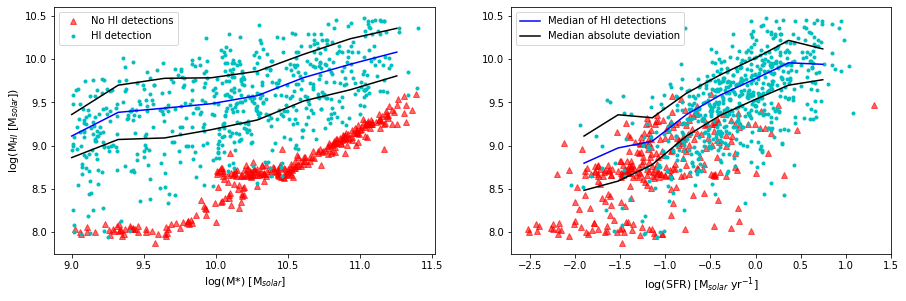

In [ ]:
# Global HI mass and HI mass contained in the optical regions with median lines
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar2, lgMHI2, 'r^', label= 'No HI detections', alpha=0.6)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(bins_HIgl_Mstar[:-2], median_HIgl_Mstar[:-2], 'b-')
plt.plot(bins_HIgl_Mstar[:-2], pMAD_HIgl_Mstar[:-2], 'k-')
plt.plot(bins_HIgl_Mstar[:-2], nMAD_HIgl_Mstar[:-2], 'k-')
plt.xlabel('log(M*) [M$_{solar}$]', fontsize=11)
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])', fontsize=11)
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best2), lgMHI2, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(bins_HIgl_SFR[:-2], median_HIgl_SFR[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins_HIgl_SFR[:-2], pMAD_HIgl_SFR[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins_HIgl_SFR[:-2], nMAD_HIgl_SFR[:-2], 'k-')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]', fontsize=11)
plt.legend(loc='upper left');

3) Fitting the xGASS galaxies to the surface-density profile

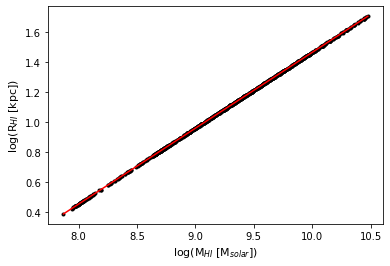

In [ ]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI
# For HI detections
lgDHI1 = 0.506*lgMHI1 - 3.293
MHI1 = 10**lgMHI1
DHI1 = 10**lgDHI1
RHI1 = 0.5*DHI1
# For no HI detection
lgDHI2 = 0.506*lgMHI2 - 3.293
MHI2 = 10**lgMHI2
DHI2 = 10**lgDHI2
RHI2 = 0.5*DHI2

# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(np.log10(MHI), np.log10(RHI), 'k.')
plt.ylabel('log(R$_{HI}$ [kpc])', fontsize=11)
plt.xlabel('log(M$_{HI}$ [M$_{solar}$])', fontsize=11)

# Fitting a line to the RHI-MHI relation
x = np.log10(MHI)
p = np.linspace(min(x), max(x), 100)
y = np.log10(RHI)
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
plt.plot(p, linfun(p, *popt), 'r');

-0.9639211636046359
-1.2288723228732537


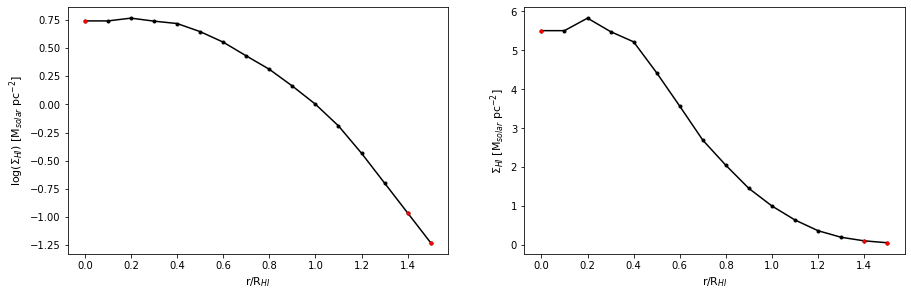

In [ ]:
# Need to create a median HI profile of galaxies- (data from Wang et al 2020)
rrHI=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
SigHI=np.array([5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
lgSigHI = np.log10(SigHI)

# This data has no 0 point and some of the xGASS samples will extend further than the 1.3 r/RHI in the rrHI array, out to 1.5
# Therefore the following will linearly extrapolate:
# Back to the zero-point
x1 = np.flip(rrHI)
y1 = lgSigHI
f1 = interpolate.interp1d(x1, y1, fill_value = "extrapolate")
zpoint = f1(max(x1))
# Forward to 1.5r/RHI
x2 = rrHI
y2 = y1
f2 = interpolate.interp1d(x2, y2, fill_value = "extrapolate")
z1point = f2(1.4)
z2point = f2(1.5)

# New arrays to fit the surface density profile to
newrrHI = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
newSigHI=np.array([(10**zpoint),5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2,(10**z1point),(10**z2point)])
newlgSigHI = np.log10(newSigHI)
'''
# Fitting a curve to the extrapolated data
x = newrrHI
p = np.linspace(0, max(newrrHI), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)
'''

# Plotting the median HI profile using Wang 2020 data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(newrrHI, newlgSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$', fontsize=11)
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]', fontsize=11)
#plt.plot(p, curvefun(p, *popt), 'r-')
plt.plot(0, zpoint, 'r.')
plt.plot(1.4, z1point, 'r.')
plt.plot(1.5, z2point, 'r.');

plt.subplot(222)
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$', fontsize=11)
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]', fontsize=11)
#plt.plot(p, 10**curvefun(p, *popt), 'r-')
plt.plot(0, 10**zpoint, 'r.')
plt.plot(1.4, 10**z1point, 'r.')
plt.plot(1.5, 10**z2point, 'r.');

print(z1point)
print(z2point)

4) Integrating over each profile to see the accuracy between predicted total HI mass and the HI mass from xGASS

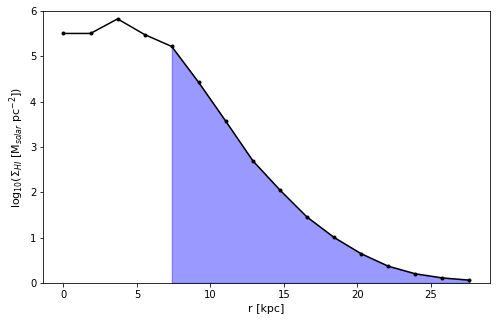

In [ ]:
# Each galaxy from the xGASS representative sample can be assumed to follow the same surface density profile as modelled previously
# Rescaling the x-axis by multiplying r/RHI by the 'i'th value in the RHI array determined from the mass relation
# In this case multiplying the r/RHI in the mass relation by the value of RHI for the first galaxy
'''
# Rescaling the curvefitting routine to use the rescaled x-axis
x = newrrHI*RHI[0]
p = np.linspace(0, max((newrrHI*RHI[0])), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)
'''
# Plotting the surface-density profile for the first galaxy in xGASS
plt.figure(figsize = (8,5))
plt.plot(newrrHI*RHI[0], newSigHI, 'k.-')
#plt.plot(p, curvefun(p, *popt), 'r-')
plt.xlabel('r [kpc]', fontsize=11)
plt.ylabel('log$_{10}$(Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$])', fontsize=11)
plt.fill_between(x[4:16], newSigHI[4:16], color= 'blue', alpha = 0.4)
plt.ylim(0,6);

In [ ]:
# To compare the predicted global HI mass to the measured global HI mass we need to integrate under the surface-density profile
# This will be run for all of the galaxies and then the expected global HI mass can be plotted against the measured global HI mass
# The less scatter present in this relation the more accurate the process to determine the HI mass outside the optical region will be
ScaleR0 = newrrHI*RHI[0]
SclR0pc = ScaleR0*1000
SclR0pc2 = np.pi*((SclR0pc)**2)
Sd = 10**newlgSigHI

# Computing the integration via the trapezium method:
x_arr0 = SclR0pc2
y_arr0 = Sd
dx0 = (x_arr0[15] - x_arr0[0]) / len(x_arr0)
areas0 = np.trapz(y_arr0[0:15], x_arr0[0:15], dx = dx0)
mHIpred0 = areas0
print(np.log10(mHIpred0))
print(lgMHI[0])

9.565248700463425
9.603


In [ ]:
# Loop the process of rescaling, creating the surface-density profile and computing the integration for all galaxies
# Creating arrays of zeroes to store output data
rrl = len(newrrHI)
Rl = len(RHI)
ScaleR = np.zeros(rrl)
areas = np.zeros(Rl)
MHIpred = np.zeros(Rl)

for i in range(Rl):

  # Rescaling x-axis
  # Takes r/RHI and multiplies by the HI radius for each galaxy
  ScaleR = newrrHI*RHI[i]
  # Converts from  kpc to pc
  SclRpc = ScaleR*1000
  # Approximate each galaxy HI as a flat disk, the area of a circle with radius r [pc]
  SclRpc2 = np.pi*((SclRpc)**2)

  # Rescaling the y-axis
  # Removing the log10 from the surface density
  Sd = 10**newlgSigHI
  
  # Trapezoidal integration
  x_arr = SclRpc2
  y_arr = Sd
  dx = (x_arr[15] - x_arr[0]) / len(x_arr[0:15])
  areas[i] = np.trapz(y_arr[0:15], x_arr[0:15], dx = dx)
  MHIpred[i] = areas[i]

Gradient:  0.9352506064734352 +/- 0.00019517144471168784


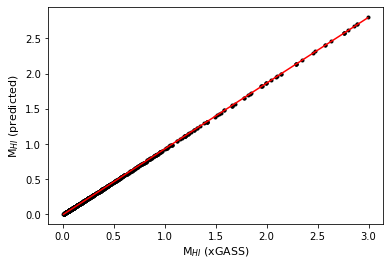

In [ ]:
# Comparing how well the total predicted HI mass compares to the total HI mass from xGASS
MassHI = 10**lgMHI
MassHIpred = MHIpred
rescale_MassHI = MassHI / 1e10
rescale_MassHIpred = MHIpred / 1e10
# Fitting a line to the MHI(predicted) - MHI(xGASS) relation
x = rescale_MassHI
p = np.linspace(min(x), max(x), 100)
y = rescale_MassHIpred
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
# Plotting
plt.plot(rescale_MassHI, rescale_MassHIpred, 'k.')
plt.xlabel('M$_{HI}$ (xGASS)', fontsize= 11)
plt.ylabel('M$_{HI}$ (predicted)', fontsize = 11)
plt.plot(p, linfun(p, *popt), 'r')
print ('Gradient: ', popt[0], '+/-', np.sqrt(pcov.diagonal()[0])) ;

5) Optical radius: 90% of the flux emitted in the r-band, integrating over this for all galaxies. We then can find the HI mass contained within the optical region of a galaxy

In [ ]:
# Converting the petrosian flux in the r band from arcsec to parsec:
# Using the astropy cosmology module
# Assuming the following cosmology
cosmology = FlatLambdaCDM(H0 = 70, Om0 = 0.3, Tcmb0 = 2.273)
# Converting the data, where .arcsec_per_kpc_proper is the equation of proper distance, using the redshift of the galaxies
arckpc1 = cosmology.arcsec_per_kpc_proper(zSDSS1)
rkpc = petro90r1/arckpc1
print(rkpc[0:11])

[7.55712078 5.8121283  5.89997902 5.87567543 6.26790544 5.22446464
 9.07191737 4.99415006 5.77196448 8.82255907 4.18101217] kpc / arcsec


In [ ]:
# To estimate the HI mass inside the optical region of the galaxy a radius is selected that lies on the x-axis for the surface density relation plot
# This radius to 1.5x the radius of the HI region for a given galaxy is then integrated over, this gives the HI mass outside the optical region of the galaxy
# The optical region of the galaxy can be defined in various ways:

# 1) The region that encloses 90% of the optical light (petrosian flux 90% in the r-band)
# Using the optical region as the radius that encloses 90% of the flux in the optical band, we use the equations:
# Angular diameter distance of a galaxy at redshift z:
# DA(z) = DL(z)/(1+z)^2
# Definition of angular diameter distance:
# Theta = size(l)/DA(z)
# Combining these to an expression of the size of a galaxy in kpc, will allow the conversion of the petrosian 90 r band data from units of arcsec to parsec
# This then allows for the calculation of r90 in kpc and the scaling to find the surface density for each galaxy, using the profile estabilished above
# Function:
def arcpc(z, theta, Dlumin):
  arcrad = ((2*np.pi)/360) * (1/3600)
  return (Dlumin* arcrad * theta) / ((1+z)**2)

Rkpc = arcpc(zSDSS, petro90r, Dlum) * 1000
Rkpc1 = arcpc(zSDSS1, petro90r1, Dlum1) * 1000
Rkpc2 = arcpc(zSDSS2, petro90r2, Dlum2) * 1000
print(Rkpc[0:11])
print(rkpc[0:11])

[7.5552745 7.0760946 5.8124747 5.9020486 4.1215577 5.874771  6.2682405
 5.2238584 5.629328  8.635725  3.8034928]
[7.55712078 5.8121283  5.89997902 5.87567543 6.26790544 5.22446464
 9.07191737 4.99415006 5.77196448 8.82255907 4.18101217] kpc / arcsec


In [ ]:
# Integrating under the surface density profile with a given r(90) optical radius
# R(90) was converted from arcsec to kpc and can be converted and rescaled the same as the x-axis from previous
ScaleR0 = newrrHI*RHI[0]
SclR0pc = ScaleR0*1000
SclR0pc2 = np.pi*((SclR0pc)**2)
Sd = 10**newlgSigHI
R90pc = Rkpc[0]*1000 # <---- REMEMBER THIS WILL CHANGE WITH 'i' LIKE RHI[i]
R90pc20 = np.pi*((R90pc)**2)

# Finding the y-coordinate of R90pc2(0) via interpolation for the first galaxy
polate = interpolate.interp1d(SclR0pc2, Sd, fill_value = 'extrapolate')
newy = polate(R90pc20)

In [ ]:
# Computing the integration via the trapezium method:
# Placing r90 x-coordinate inside the array of the preexisting x-coordinate array
placerx = np.append(SclR0pc2, R90pc20)
x_sort = np.sort(placerx)
x_arr = x_sort[np.where(x_sort >= R90pc20)[0]]
print(x_arr)
# Placing r90 y-coordinate inside the array of the preexisting y-coordinate array
y_arr0 = Sd
placery = np.append(y_arr0, newy)
y_sort = np.sort(placery)
y_insort = y_sort[::-1]
y_arr = y_insort[np.where(x_sort >= R90pc20)[0]]
print(y_arr)

# Integrating
dx0 = (x_arr[-1] - x_arr[0]) / len(x_arr)
areasOUT = np.trapz(y_arr[0:-1], x_arr[0:-1], dx = dx0)
MHIpredout = areasOUT
print(MHIpredout)
print(10**lgMHI[0])

[1.79328934e+08 2.66234873e+08 3.83378216e+08 5.21820350e+08
 6.81561274e+08 8.62600987e+08 1.06493949e+09 1.28857678e+09
 1.53351287e+09 1.79974774e+09 2.08728140e+09 2.39611385e+09]
[5.14355227 4.42226    3.56687    2.69376    2.0485     1.45364
 1.00281    0.643707   0.368113   0.2        0.10866229 0.05903746]
2689292111.1596937
4008664288.989304


In [ ]:
# Process for the first galaxy returns resonable answers for the mass of HI (predicted) outside the defined optical radius
# The mass HI (predicted, out) can be looped over all galaxies:
Rl = len(RHI)
areasOUT = np.zeros(Rl)
MHIpredoutr90 = np.zeros(Rl)

for i in range(Rl):

  # Rescaling x-axis
  # Takes r/RHI and multiplies by the HI radius for each galaxy
  ScaleR = newrrHI*RHI[i]
  # Converts from  kpc to pc
  SclRpc = ScaleR*1000
  # Approximate each galaxy HI as a flat disk, the area of a circle with radius r [pc]
  SclRpc2 = np.pi*((SclRpc)**2)

  # Rescaling the y-axis
  # Removing the log10 from the surface density
  Sd = 10**newlgSigHI

  # Radius of the optical region of a given galaxy, contains 90% flux in the r-band
  R90pc = Rkpc[i]*1000 
  R90pc2 = np.pi*((R90pc)**2)

  # Finding the y-coordinate of R90pc2 for each galaxy via interpolation
  polate = interpolate.interp1d(SclRpc2, Sd, fill_value = 'extrapolate')
  newy = polate(R90pc2)

  # Placing r90 x-coordinate inside the array of the preexisting x-coordinate array
  placerx = np.append(SclRpc2, R90pc2)
  x_sort = np.sort(placerx)
  x_arr = x_sort[np.where(x_sort >= R90pc2)[0]]

  # Placing r90 y-coordinate inside the array of the preexisting y-coordinate array
  y_arr0 = Sd
  placery = np.append(y_arr0, newy)
  y_sort = np.sort(placery)
  y_insort = y_sort[::-1]
  y_arr = y_insort[np.where(x_sort >= R90pc2)[0]]

  # Trapezoidal integration
  dx0 = (x_arr[-1] - x_arr[0]) / len(x_arr)
  areasOUT[i] = np.trapz(y_arr, x_arr, dx = dx0)
  MHIpredoutr90[i] = areasOUT[i]

In [ ]:
# Using the equation MHI(predicted, inside optical) = MHI(global) - MHI(predicted, outside optical)
MHIpredinr90 = (10**lgMHI) - MHIpredoutr90

# Separating MHI(predicted, inside optical) into HI detections and non-HI detections
MHIpredin1r90 = np.delete(MHIpredinr90, (HIndet))
MHIpredin2r90 = np.delete(MHIpredinr90, (HIdet))

lgMHIpredinr90 = np.log10(MHIpredinr90)
lgMHIpredin1r90 = np.log10(MHIpredin1r90)
lgMHIpredin2r90 = np.log10(MHIpredin2r90)

# Checking that HI mass in the optical region is smaller than the total HI mass
print(len(np.where(MHIpredinr90 > (10**lgMHI))[0]))

0


6) Plotting the results of this integration and comparing with the global HI mass

In [ ]:
# Finding the running median of the HI detections inside the optical region
# Arrays for the bins
bins_HIin_r90_Mstar = np.linspace(9, 11.9, 10)
bins_HIin_r90_SFR = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
median_HIin_r90_Mstar = np.zeros(len(bins_HIin_r90_Mstar))
MAD_HIin_r90_Mstar = np.zeros(len(bins_HIin_r90_Mstar))

median_HIin_r90_SFR = np.zeros(len(bins_HIin_r90_SFR))
MAD_HIin_r90_SFR = np.zeros(len(bins_HIin_r90_SFR))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_HIin_r90_Mstar) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median_HIin_r90_Mstar[i] = np.median(lgMHIpredin1r90[np.where((lgMstar1 >= bins_HIin_r90_Mstar[i]) & (lgMstar1 <= bins_HIin_r90_Mstar[i+1]))])
  MAD_HIin_r90_Mstar[i] = stats.median_abs_deviation(lgMHIpredin1r90[np.where((lgMstar1 >= bins_HIin_r90_Mstar[i]) & (lgMstar1 <= bins_HIin_r90_Mstar[i+1]))])

  # Median and MAD for HI of galaxies against SFR
  median_HIin_r90_SFR[i] = np.median(lgMHIpredin1r90[np.where((lgSFR1 >= bins_HIin_r90_SFR[i]) & (lgSFR1 <= bins_HIin_r90_SFR[i+1]))])
  MAD_HIin_r90_SFR[i] = stats.median_abs_deviation(lgMHIpredin1r90[np.where((lgSFR1 >= bins_HIin_r90_SFR[i]) & (lgSFR1 <= bins_HIin_r90_SFR[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
pMAD_HIin_r90_Mstar = median_HIin_r90_Mstar + MAD_HIin_r90_Mstar
nMAD_HIin_r90_Mstar = median_HIin_r90_Mstar - MAD_HIin_r90_Mstar
pMAD_HIin_r90_SFR = median_HIin_r90_SFR + MAD_HIin_r90_SFR
nMAD_HIin_r90_SFR = median_HIin_r90_SFR - MAD_HIin_r90_SFR

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


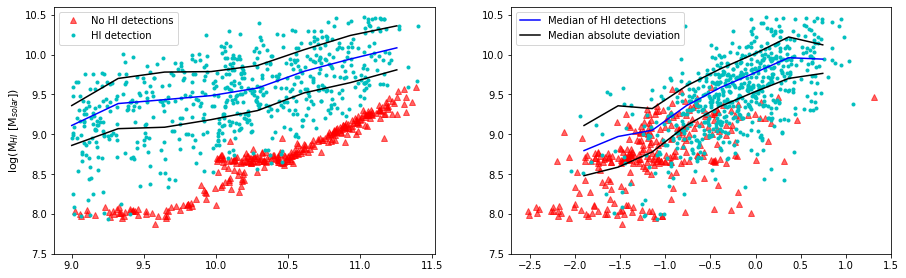

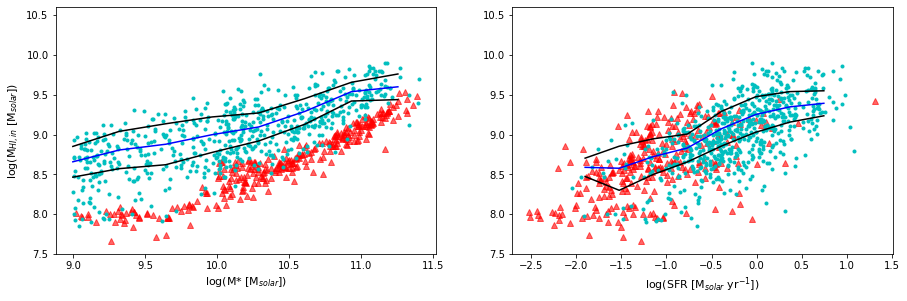

In [ ]:
# Global HI mass against stellar mass and SFR
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar2, lgMHI2, 'r^', alpha=0.6, label= 'No HI detections')
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(bins_HIgl_Mstar[:-2], median_HIgl_Mstar[:-2], 'b-')
plt.plot(bins_HIgl_Mstar[:-2], pMAD_HIgl_Mstar[:-2], 'k-')
plt.plot(bins_HIgl_Mstar[:-2], nMAD_HIgl_Mstar[:-2], 'k-')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])', fontsize=11)
plt.legend(loc='upper left')
plt.ylim(7.5, 10.6)

plt.subplot(222)
plt.plot(np.log10(SFR_best2), lgMHI2, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(bins_HIgl_SFR[:-2], median_HIgl_SFR[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins_HIgl_SFR[:-2], pMAD_HIgl_SFR[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins_HIgl_SFR[:-2], nMAD_HIgl_SFR[:-2], 'k-')
plt.legend(loc='upper left')
plt.ylim(7.5, 10.6)

# Plotting the HI mass within the optical radius, against stellar masses and SFR
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(lgMstar2, lgMHIpredin2r90, 'r^', alpha=0.6)
plt.plot(lgMstar1, lgMHIpredin1r90, 'c.')
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])', fontsize=11)
plt.plot(bins_HIin_r90_Mstar[:-2], median_HIin_r90_Mstar[:-2], 'b-')
plt.plot(bins_HIin_r90_Mstar[:-2], pMAD_HIin_r90_Mstar[:-2], 'k-')
plt.plot(bins_HIin_r90_Mstar[:-2], nMAD_HIin_r90_Mstar[:-2], 'k-')
plt.ylim(7.5, 10.6)

plt.subplot(222)
plt.plot(np.log10(SFR_best2), lgMHIpredin2r90, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHIpredin1r90, 'c.')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.plot(bins_HIin_r90_SFR[:-2], median_HIin_r90_SFR[:-2], 'b-')
plt.plot(bins_HIin_r90_SFR[:-2], pMAD_HIin_r90_SFR[:-2], 'k-')
plt.plot(bins_HIin_r90_SFR[:-2], nMAD_HIin_r90_SFR[:-2], 'k-')
plt.ylim(7.5, 10.6);

7) Optical radius: 2x the effective radius of the disk measured in the r-band. Following the same integration procedure as before

In [ ]:
# Another definition of the optical region of a galaxy would be to take the effective radius and double it
# The effective radius is the radius enclosing 50% of the emitted light of a galaxy, in the r-band this would be 50% of the optical light
# Using the xGASS decomposition data from Cook et al 2019 we can use the effective radius in the r-band of the disk of a galaxy rather than the whole galaxy radius
# The radii from the decomposition catalogue are the radii of the Sersic profile in pixels

# Where the conversion for pixels to arcseconds is 0.396"/pixel:
# Since the effective radius is only half the emitted light we need to double this radius:
effrDpix = reD_r
effrDarc = effrDpix * 0.396 * 2

# 2) Effective radius of the disk component, doubled
# Calling the arcsecond --> parsec function again
effRkpc = arcpc(zSDSS, effrDarc, Dlum) * 1000

print(effRkpc[0:11])
print(Rkpc[0:11])

[10.95919231  9.98150456  9.56815279  7.99022237  5.50663407  9.14754661
  6.74453861  7.25028028  6.69830867  7.44979649  4.91885191]
[7.5552745 7.0760946 5.8124747 5.9020486 4.1215577 5.874771  6.2682405
 5.2238584 5.629328  8.635725  3.8034928]


In [ ]:
# The global HI mass graphs will stay the same, however the integration process will be repeated for the new optical radius, subsituting in effective disk radius
# The mass HI (predicted, out) can be looped over all galaxies:
Rl = len(RHI)
areasOUT = np.zeros(Rl)
MHIpredout2eff = np.zeros(Rl)

for i in range(Rl):

  # Rescaling x-axis
  # Takes r/RHI and multiplies by the HI radius for each galaxy
  ScaleR = newrrHI*RHI[i]
  # Converts from  kpc to pc
  SclRpc = ScaleR*1000
  # Approximate each galaxy HI as a flat disk, the area of a circle with radius r [pc]
  SclRpc2 = np.pi*((SclRpc)**2)

  # Rescaling the y-axis
  # Removing the log10 from the surface density
  Sd = 10**newlgSigHI

  # Radius of the optical region of a given galaxy, effective radius of the disk doubled
  effRpc = effRkpc[i]*1000 
  effRpc2 = np.pi*((effRpc)**2)

  # Finding the y-coordinate of R90pc2 for each galaxy via interpolation
  polate = interpolate.interp1d(SclRpc2, Sd, fill_value = 'extrapolate')
  newy = polate(effRpc2)

  # Placing r90 x-coordinate inside the array of the preexisting x-coordinate array
  placerx = np.append(SclRpc2, effRpc2)
  x_sort = np.sort(placerx)
  x_arr = x_sort[np.where(x_sort >= effRpc2)[0]]

  # Placing r90 y-coordinate inside the array of the preexisting y-coordinate array
  y_arr0 = Sd
  placery = np.append(y_arr0, newy)
  y_sort = np.sort(placery)
  y_insort = y_sort[::-1]
  y_arr = y_insort[np.where(x_sort >= effRpc2)[0]]
  # Trapezoidal integration
  dx0 = (x_arr[-1] - x_arr[0]) / len(x_arr)
  
  areasOUT[i] = np.trapz(y_arr, x_arr, dx = dx0)
  MHIpredout2eff[i] = areasOUT[i]

In [ ]:
# Using the equation MHI(predicted, inside optical) = MHI(global) - MHI(predicted, outside optical)
MHIpredin2eff = (10**lgMHI) - MHIpredout2eff

# Separating MHI(predicted, inside optical) into HI detections and non-HI detections
MHIpredin12eff = np.delete(MHIpredin2eff, (HIndet))
MHIpredin22eff = np.delete(MHIpredin2eff, (HIdet))

lgMHIpredin2eff = np.log10(MHIpredin2eff)
lgMHIpredin12eff = np.log10(MHIpredin12eff)
lgMHIpredin22eff = np.log10(MHIpredin22eff)

# Checking that the predicted HI mass inside the optical region is smaller than the total HI mass
print(len(np.where(MHIpredin2eff > (10**lgMHI))[0]))

0


8) Plotting the global HI mass in comparison to the HI mass inside the optical region (effective radius)

In [ ]:
# Finding the running median of the HI mass globally and within the optical region
# Arrays for the bins
bins_HIin_Reff_Mstar = np.linspace(9, 11.9, 10)
bins_HIin_Reff_SFR = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
median_HIin_Reff_Mstar = np.zeros(len(bins_HIin_Reff_Mstar))
MAD_HIin_Reff_Mstar = np.zeros(len(bins_HIin_Reff_Mstar))

median_HIin_Reff_SFR = np.zeros(len(bins_HIin_Reff_SFR))
MAD_HIin_Reff_SFR = np.zeros(len(bins_HIin_Reff_SFR))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_HIin_Reff_Mstar) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median_HIin_Reff_Mstar[i] = np.median(lgMHIpredin12eff[np.where((lgMstar1 >= bins_HIin_Reff_Mstar[i]) & (lgMstar1 <= bins_HIin_Reff_Mstar[i+1]))])
  MAD_HIin_Reff_Mstar[i] = stats.median_abs_deviation(lgMHIpredin12eff[np.where((lgMstar1 >= bins_HIin_Reff_Mstar[i]) & (lgMstar1 <= bins_HIin_Reff_Mstar[i+1]))])

  # Median and MAD for HI of galaxies against SFR
  median_HIin_Reff_SFR[i] = np.median(lgMHIpredin12eff[np.where((np.log10(SFR_best1) >= bins_HIin_Reff_SFR[i]) & (np.log10(SFR_best1) <= bins_HIin_Reff_SFR[i+1]))])
  MAD_HIin_Reff_SFR[i] = stats.median_abs_deviation(lgMHIpredin12eff[np.where((np.log10(SFR_best1) >= bins_HIin_Reff_SFR[i]) & (np.log10(SFR_best1) <= bins_HIin_Reff_SFR[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
pMAD_HIin_Reff_Mstar = median_HIin_Reff_Mstar + MAD_HIin_Reff_Mstar
nMAD_HIin_Reff_Mstar = median_HIin_Reff_Mstar - MAD_HIin_Reff_Mstar
pMAD_HIin_Reff_SFR = median_HIin_Reff_SFR + MAD_HIin_Reff_SFR
nMAD_HIin_Reff_SFR = median_HIin_Reff_SFR - MAD_HIin_Reff_SFR

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


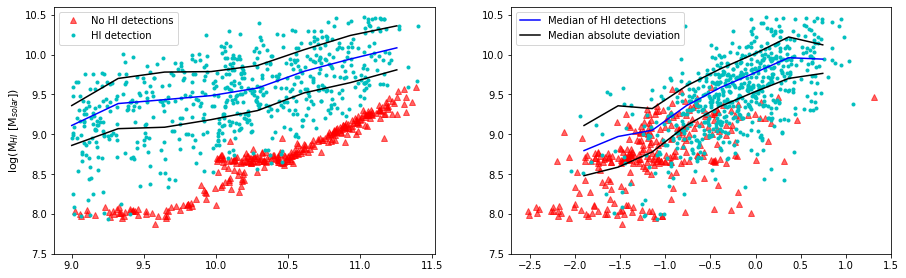

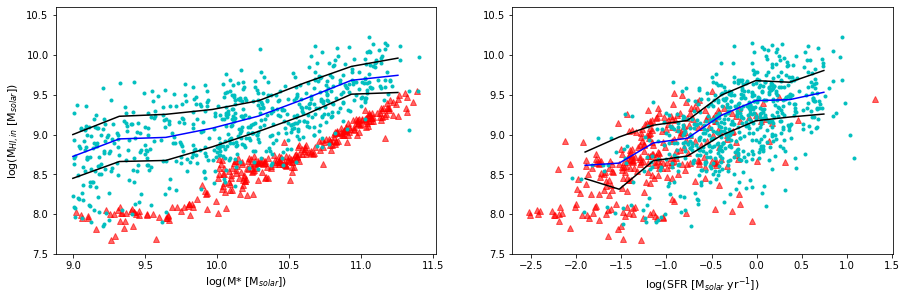

In [ ]:
# Plotting the global HI mass against stellar masses and SFR
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(lgMstar2, lgMHI2, 'r^', alpha=0.6, label= 'No HI detections')
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(bins_HIgl_Mstar[:-2], median_HIgl_Mstar[:-2], 'b-')
plt.plot(bins_HIgl_Mstar[:-2], pMAD_HIgl_Mstar[:-2], 'k-')
plt.plot(bins_HIgl_Mstar[:-2], nMAD_HIgl_Mstar[:-2], 'k-')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])', fontsize=11)
plt.legend(loc='upper left')
plt.ylim(7.5, 10.6);

plt.subplot(222)
plt.plot(np.log10(SFR_best2), lgMHI2, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(bins_HIgl_SFR[:-2], median_HIgl_SFR[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins_HIgl_SFR[:-2], pMAD_HIgl_SFR[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins_HIgl_SFR[:-2], nMAD_HIgl_SFR[:-2], 'k-')
plt.legend(loc='upper left')
plt.ylim(7.5, 10.6);

# Plotting the HI mass within the optical radius (effective radius of the disk), against stellar masses and SFR
plt.figure(figsize = (15,10))
plt.subplot(223)
plt.plot(lgMstar2, lgMHIpredin22eff, 'r^', alpha=0.6)
plt.plot(lgMstar1, lgMHIpredin12eff, 'c.')
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])', fontsize=11)
plt.plot(bins_HIin_Reff_Mstar[:-2], median_HIin_Reff_Mstar[:-2], 'b-')
plt.plot(bins_HIin_Reff_Mstar[:-2], pMAD_HIin_Reff_Mstar[:-2], 'k-')
plt.plot(bins_HIin_Reff_Mstar[:-2], nMAD_HIin_Reff_Mstar[:-2], 'k-')
plt.ylim(7.5, 10.6);

plt.subplot(224)
plt.plot(np.log10(SFR_best2), lgMHIpredin22eff, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHIpredin12eff, 'c.')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.plot(bins_HIin_Reff_SFR[:-2], median_HIin_Reff_SFR[:-2], 'b-')
plt.plot(bins_HIin_Reff_SFR[:-2], pMAD_HIin_Reff_SFR[:-2], 'k-')
plt.plot(bins_HIin_Reff_SFR[:-2], nMAD_HIin_Reff_SFR[:-2], 'k-')
plt.ylim(7.5, 10.6);

9) Plotting the HI total mass, HI mass in the optical region defined by R90 and the HI mass in the optical region defined by 2Reff against stellar mass and SFR

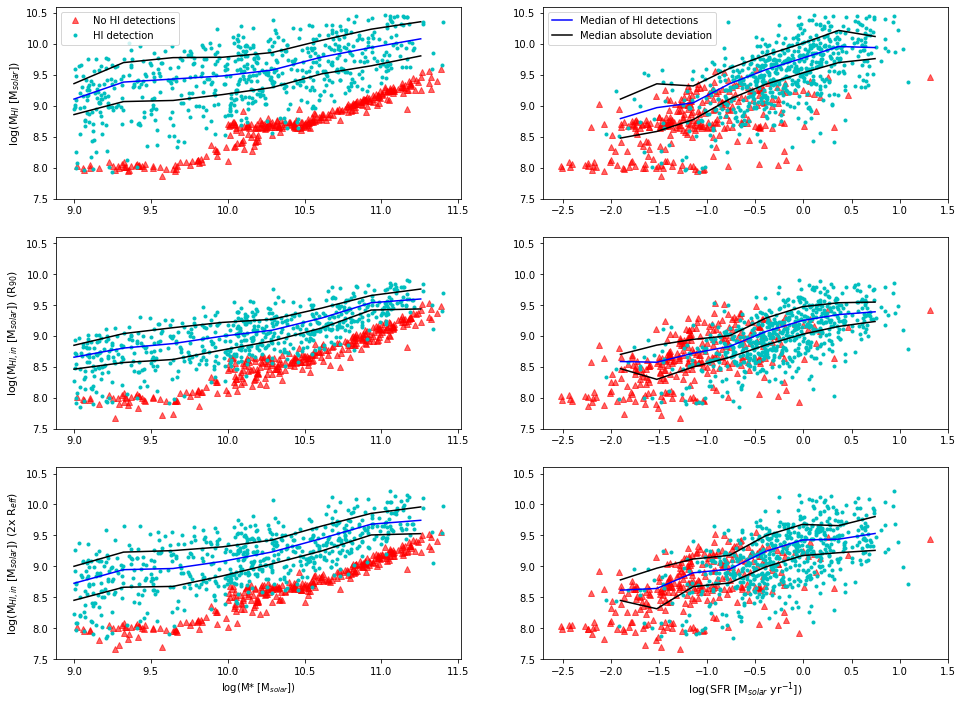

In [ ]:
# Global HI mass against stellar mass and SFR
plt.figure(figsize = (16,12))

plt.subplot(321)
plt.plot(lgMstar2, lgMHI2, 'r^', alpha=0.6, label= 'No HI detections')
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(bins_HIgl_Mstar[:-2], median_HIgl_Mstar[:-2], 'b-')
plt.plot(bins_HIgl_Mstar[:-2], pMAD_HIgl_Mstar[:-2], 'k-')
plt.plot(bins_HIgl_Mstar[:-2], nMAD_HIgl_Mstar[:-2], 'k-')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])', fontsize=11)
plt.legend(loc='upper left')
plt.ylim(7.5, 10.6)

plt.subplot(322)
plt.plot(np.log10(SFR_best2), lgMHI2, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(bins_HIgl_SFR[:-2], median_HIgl_SFR[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins_HIgl_SFR[:-2], pMAD_HIgl_SFR[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins_HIgl_SFR[:-2], nMAD_HIgl_SFR[:-2], 'k-')
plt.legend(loc='upper left')
plt.ylim(7.5, 10.6)

# Plotting the HI mass within the optical radius, against stellar masses and SFR
plt.subplot(323)
plt.plot(lgMstar2, lgMHIpredin2r90, 'r^', alpha=0.6)
plt.plot(lgMstar1, lgMHIpredin1r90, 'c.')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$]) (R$_{90}$)', fontsize=11)
plt.plot(bins_HIin_r90_Mstar[:-2], median_HIin_r90_Mstar[:-2], 'b-')
plt.plot(bins_HIin_r90_Mstar[:-2], pMAD_HIin_r90_Mstar[:-2], 'k-')
plt.plot(bins_HIin_r90_Mstar[:-2], nMAD_HIin_r90_Mstar[:-2], 'k-')
plt.ylim(7.5, 10.6)

plt.subplot(324)
plt.plot(np.log10(SFR_best2), lgMHIpredin2r90, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHIpredin1r90, 'c.')
plt.plot(bins_HIin_r90_SFR[:-2], median_HIin_r90_SFR[:-2], 'b-')
plt.plot(bins_HIin_r90_SFR[:-2], pMAD_HIin_r90_SFR[:-2], 'k-')
plt.plot(bins_HIin_r90_SFR[:-2], nMAD_HIin_r90_SFR[:-2], 'k-')
plt.ylim(7.5, 10.6)

# Plotting the HI mass within the optical radius (effective radius of the disk), against stellar masses and SFR
plt.subplot(325)
plt.plot(lgMstar2, lgMHIpredin22eff, 'r^', alpha=0.6)
plt.plot(lgMstar1, lgMHIpredin12eff, 'c.')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$]) (2x R$_{eff}$)', fontsize=11)
plt.plot(bins_HIin_Reff_Mstar[:-2], median_HIin_Reff_Mstar[:-2], 'b-')
plt.plot(bins_HIin_Reff_Mstar[:-2], pMAD_HIin_Reff_Mstar[:-2], 'k-')
plt.plot(bins_HIin_Reff_Mstar[:-2], nMAD_HIin_Reff_Mstar[:-2], 'k-')
plt.ylim(7.5, 10.6);

plt.subplot(326)
plt.plot(np.log10(SFR_best2), lgMHIpredin22eff, 'r^', alpha=0.6)
plt.plot(np.log10(SFR_best1), lgMHIpredin12eff, 'c.')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.plot(bins_HIin_Reff_SFR[:-2], median_HIin_Reff_SFR[:-2], 'b-')
plt.plot(bins_HIin_Reff_SFR[:-2], pMAD_HIin_Reff_SFR[:-2], 'k-')
plt.plot(bins_HIin_Reff_SFR[:-2], nMAD_HIin_Reff_SFR[:-2], 'k-')
plt.ylim(7.5, 10.6);

10) Investigating the bulge-total mass ratios for the galaxies- from the xGASS decomposition catalogue

In [ ]:
# Using the arcsec to parsec to convert the 50% petrosian flux
Rkpc_50 = arcpc(zSDSS, petro50r, Dlum) * 1000

In [ ]:
R90kpc = Rkpc
Reffkpc = effRkpc
R50kpc = Rkpc_50*2
# Looking at the model flags from the decomposition dataset of Cook et al 2019
# Applying these model flags to the r90,  2Reff and r50 radii
r90_0 = R90kpc[np.where(MFlag > 0)]
r90_1 = R90kpc[np.where((MFlag > 1) & (MFlag < 3))[0]]
r90_2 = R90kpc[np.where((MFlag > 2) & (MFlag < 4))[0]]
r90_3 = R90kpc[np.where((MFlag > 3) & (MFlag < 5))[0]]
r90_4 = R90kpc[np.where(MFlag > 5)[0]]
rEff_0 = Reffkpc[np.where(MFlag > 0)]
rEff_1 = Reffkpc[np.where((MFlag > 1) & (MFlag < 3))[0]]
rEff_2 = Reffkpc[np.where((MFlag > 2) & (MFlag < 4))[0]]
rEff_3 = Reffkpc[np.where((MFlag > 3) & (MFlag < 5))[0]]
rEff_4 = Reffkpc[np.where(MFlag > 5)[0]]
r50_0 = R50kpc[np.where(MFlag > 0)]
r50_1 = R50kpc[np.where((MFlag > 1) & (MFlag < 3))[0]]
r50_2 = R50kpc[np.where((MFlag > 2) & (MFlag < 4))[0]]
r50_3 = R50kpc[np.where((MFlag > 3) & (MFlag < 5))[0]]
r50_4 = R50kpc[np.where(MFlag > 5)[0]]

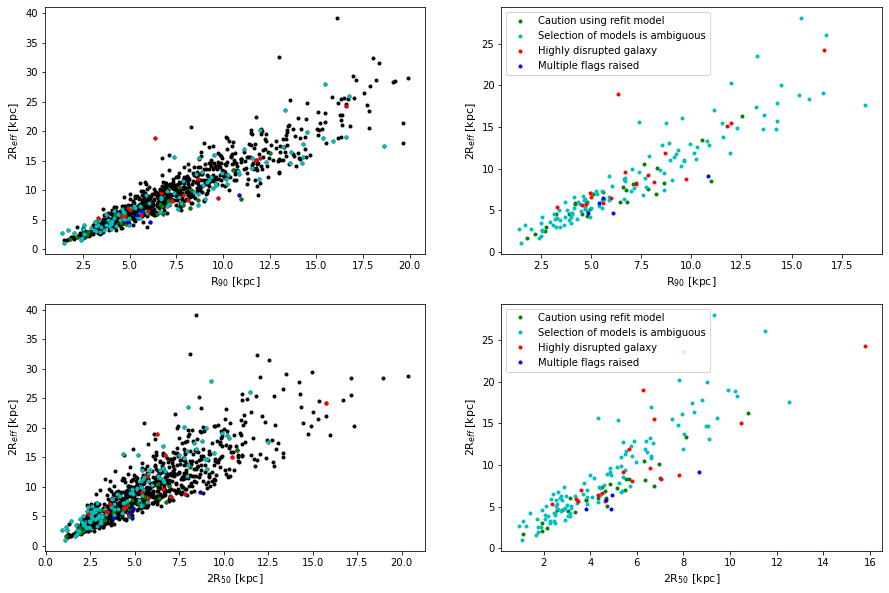

In [ ]:
# To determine how closely the two radii relate to each other, we plot them against each other
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(R90kpc, Reffkpc, 'k.')
plt.plot(r90_1, rEff_1, 'g.')
plt.plot(r90_2, rEff_2, 'c.')
plt.plot(r90_3, rEff_3, 'r.')
plt.plot(r90_4, rEff_4, 'b.')
plt.ylabel('2R$_{eff}$ [kpc]', fontsize=11)
plt.xlabel('R$_{90}$ [kpc]', fontsize=11)

plt.subplot(222)
plt.plot(r90_1, rEff_1, 'g.', label='Caution using refit model')
plt.plot(r90_2, rEff_2, 'c.', label='Selection of models is ambiguous')
plt.plot(r90_3, rEff_3, 'r.', label='Highly disrupted galaxy')
plt.plot(r90_4, rEff_4, 'b.', label='Multiple flags raised')
plt.ylabel('2R$_{eff}$ [kpc]', fontsize=11)
plt.xlabel('R$_{90}$ [kpc]', fontsize=11)
plt.legend(loc='upper left')

plt.subplot(223)
plt.plot(R50kpc, Reffkpc, 'k.')
plt.plot(r50_1, rEff_1, 'g.')
plt.plot(r50_2, rEff_2, 'c.')
plt.plot(r50_3, rEff_3, 'r.')
plt.plot(r50_4, rEff_4, 'b.')
plt.ylabel('2R$_{eff}$ [kpc]', fontsize=11)
plt.xlabel('2R$_{50}$ [kpc]', fontsize=11)

plt.subplot(224)
plt.plot(r50_1, rEff_1, 'g.', label='Caution using refit model')
plt.plot(r50_2, rEff_2, 'c.', label='Selection of models is ambiguous')
plt.plot(r50_3, rEff_3, 'r.', label='Highly disrupted galaxy')
plt.plot(r50_4, rEff_4, 'b.', label='Multiple flags raised')
plt.ylabel('2R$_{eff}$ [kpc]', fontsize=11)
plt.xlabel('2R$_{50}$ [kpc]', fontsize=11)
plt.legend(loc='upper left');

In [ ]:
# From above the populations to be removed are those with ambiguity, highly disrupted galaxies and those with multiple flags raised
R90kpc = np.delete(R90kpc, (np.where(MFlag > 3)))
Reffkpc = np.delete(Reffkpc, (np.where(MFlag > 3)))
R50kpc = np.delete(R50kpc, (np.where(MFlag > 3)))
# Calculating the ratio between the radii of the two definitions of the optical regions
Rratio1 = R90kpc / Reffkpc
Rratio50 = R50kpc / Reffkpc

In [ ]:
print(len(np.where(MFlag > 3)[0]))

22


In [ ]:
# Cutting the relevant stellar mass properties
GASSid = np.delete(GASS, (np.where(MFlag > 3)))
lgMstar_cut = np.delete(lgMstar, (np.where(MFlag > 3)))
NUVr_cut = np.delete(NUVr, (np.where(MFlag > 3)))
SFR_best_cut = np.delete(SFR_best, (np.where(MFlag > 3)))
lgmust_cut = np.delete(lgmust, (np.where(MFlag > 3)))
BtoMCorr_cut = np.delete(BtoMCorr, (np.where(MFlag > 3)))
# sSFR is calculated as the star formation rate / Mstar
sSFR = SFR_best_cut / (10**lgMstar_cut)
lgsSFR = np.log10(sSFR)
B2TM = BtoMCorr_cut
Rratio = Rratio1
print('B/T > 0.6:', len(np.where(B2TM > 0.6)[0]))
print('B/T > 0.4:', len(np.where(B2TM > 0.4)[0]))
print('B/T > 0.2:', len(np.where(B2TM > 0.2)[0]))
print('B/T > 0.1:', len(np.where(B2TM > 0.1)[0]))
print('Galaxies where r90 is greater than double the effective disk radius:', len(np.where(R90kpc > Reffkpc)[0]))

B/T > 0.6: 38
B/T > 0.4: 159
B/T > 0.2: 428
B/T > 0.1: 553
Galaxies where r90 is greater than double the effective disk radius: 106


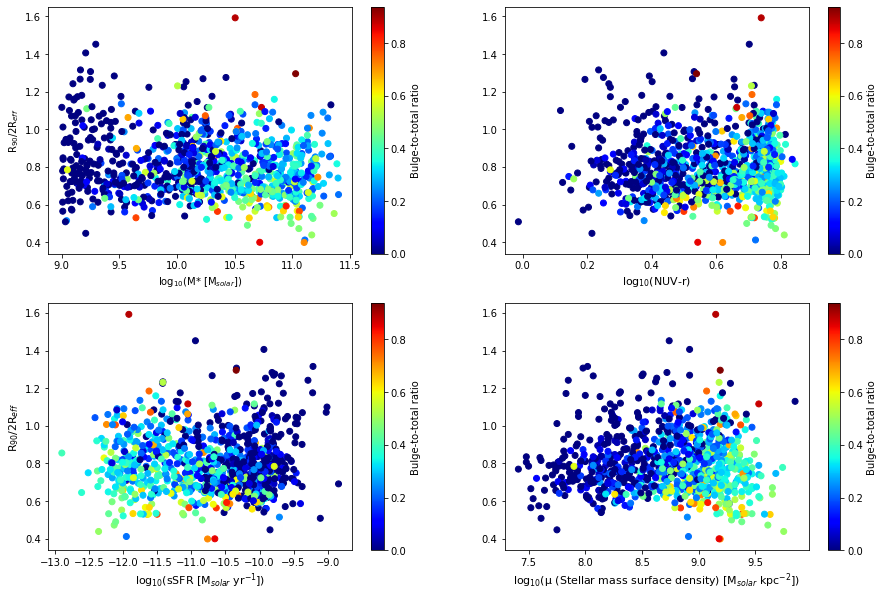

In [ ]:
# We can make a few plots that look at how well the radii ration corresponds to various galactic features from the sample
plt.figure(figsize = (15,10))

# Plotting R90/2Reff against Stellar Mass
plt.subplot(221)
plt.scatter(lgMstar_cut, Rratio, c = B2TM, cmap ='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.ylabel('R$_{90}$/2R$_{eff}$')
plt.xlabel('log$_{10}$(M* [M$_{solar}$])')

# Plotting R90/2Reff against NUV-r colour index
plt.subplot(222)
plt.scatter(np.log10(NUVr_cut), Rratio, c = B2TM, cmap='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.xlabel('log$_{10}$(NUV-r)', fontsize=11)

# Plotting R90/2Reff against sSFR, specific Star Formation Rate
plt.subplot(223)
plt.scatter(lgsSFR, Rratio, c = B2TM, cmap='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.ylabel('R$_{90}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)

# Plotting R90/2Reff against stellar mass surface density
plt.subplot(224)
plt.scatter(lgmust_cut, Rratio, c = B2TM, cmap='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.xlabel('log$_{10}$(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11);

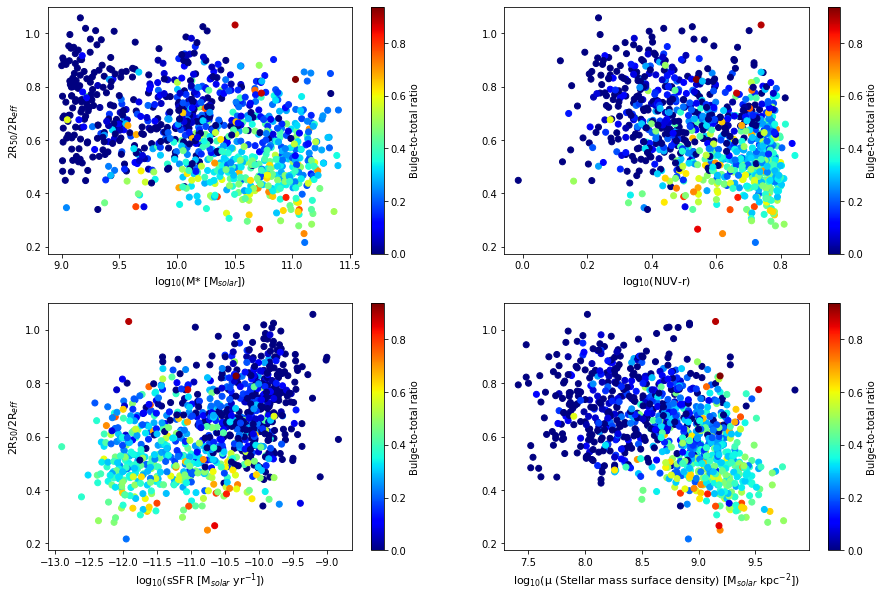

In [ ]:
# We can make a few plots that look at how well the radii ration corresponds to various galactic features from the sample
plt.figure(figsize = (15,10))

# Plotting 2R50/2Reff against Stellar Mass
plt.subplot(221)
plt.scatter(lgMstar_cut, Rratio50, c = B2TM, cmap ='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.ylabel('2R$_{50}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(M* [M$_{solar}$])', fontsize=11)

# Plotting 2R50/2Reff against NUV-r colour index
plt.subplot(222)
plt.scatter(np.log10(NUVr_cut), Rratio50, c = B2TM, cmap='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.xlabel('log$_{10}$(NUV-r)', fontsize=11)

# Plotting 2R50/2Reff against sSFR, specific Star Formation Rate
plt.subplot(223)
plt.scatter(lgsSFR, Rratio50, c = B2TM, cmap='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.ylabel('2R$_{50}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)

# Plotting 2R50/2Reff against stellar mass surface density
plt.subplot(224)
plt.scatter(lgmust_cut, Rratio50, c = B2TM, cmap='jet')
plt.colorbar(label='Bulge-to-total ratio', orientation='vertical')
plt.xlabel('log$_{10}$(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11);

11) Looking in more detail at the optical regions and comparisons between the two

In [ ]:
# Due to the large number of galaxies dominated by a disk component need to change the bins to focus more of those galaxies
# Over half the galaxies present in the sample are between 0 and 0.2 on the bulge-to-total ratio
B2TM_0 = B2TM[np.where(B2TM < 0.2)]
B2TM_02 = B2TM[np.where((B2TM > 0.2) & (B2TM < 0.4))]
B2TM_03 = B2TM[np.where(B2TM > 0.4)]

Rratio_0 = Rratio[np.where(B2TM < 0.2)]
Rratio_02 = Rratio[np.where((B2TM > 0.2) & (B2TM < 0.4))]
Rratio_03 = Rratio[np.where(B2TM > 0.4)]

Rratio50_0 = Rratio50[np.where(B2TM < 0.2)]
Rratio50_02 = Rratio50[np.where((B2TM > 0.2) & (B2TM < 0.4))]
Rratio50_03 = Rratio50[np.where(B2TM > 0.4)]

lgMstar_0 = lgMstar[np.where(B2TM < 0.2)]
lgMstar_02 = lgMstar[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMstar_03 = lgMstar[np.where(B2TM > 0.4)]

NUVr_0 = NUVr[np.where(B2TM < 0.2)]
NUVr_02 = NUVr[np.where((B2TM > 0.2) & (B2TM < 0.4))]
NUVr_03 = NUVr[np.where(B2TM > 0.4)]

lgsSFR_0 = lgsSFR[np.where(B2TM < 0.2)]
lgsSFR_02 = lgsSFR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgsSFR_03 = lgsSFR[np.where(B2TM > 0.4)]

lgmust_0 = lgmust[np.where(B2TM < 0.2)]
lgmust_02 = lgmust[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgmust_03 = lgmust[np.where(B2TM > 0.4)]

GASSid_0 = GASSid[np.where(B2TM < 0.2)]
GASSid_02 = GASSid[np.where((B2TM > 0.2) & (B2TM < 0.4))]
GASSid_03 = GASSid[np.where(B2TM > 0.4)]

In [ ]:
# Finding the running median of the galaxies 
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.5, 10)
bins_NUVr = np.linspace(0, 0.9, 10)
bins_sSFR = np.linspace(-13, -9, 10)
bins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
median_Mstar = np.zeros(len(bins_Mstar))
MAD_Mstar = np.zeros(len(bins_Mstar))

median_NUVr = np.zeros(len(bins_NUVr))
MAD_NUVr = np.zeros(len(bins_NUVr))

median_sSFR = np.zeros(len(bins_sSFR))
MAD_sSFR = np.zeros(len(bins_sSFR))

median_Must = np.zeros(len(bins_Must))
MAD_Must = np.zeros(len(bins_Must))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  median_Mstar[i] = np.median(Rratio_0[np.where((lgMstar_0 >= bins_Mstar[i]) & (lgMstar_0 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  median_NUVr[i] = np.median(Rratio_0[np.where((np.log10(NUVr_0) >= bins_NUVr[i]) & (np.log10(NUVr_0) <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  median_sSFR[i] = np.median(Rratio_0[np.where((lgsSFR_0 >= bins_sSFR[i]) & (lgsSFR_0 <= bins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  median_Must[i] = np.median(Rratio_0[np.where((lgmust_0 >= bins_Must[i]) & (lgmust_0 <= bins_Must[i+1]))])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Finding a median line for all the data present (global)
# Array of zeroes to store the median of each bin
median_Mstar_gl = np.zeros(len(bins_Mstar))
median_NUVr_gl = np.zeros(len(bins_NUVr))
median_sSFR_gl = np.zeros(len(bins_sSFR))
median_Must_gl = np.zeros(len(bins_Must))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  median_Mstar_gl[i] = np.median(Rratio[np.where((lgMstar_cut >= bins_Mstar[i]) & (lgMstar_cut <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  median_NUVr_gl[i] = np.median(Rratio[np.where((np.log10(NUVr_cut) >= bins_NUVr[i]) & (np.log10(NUVr_cut) <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  median_sSFR_gl[i] = np.median(Rratio[np.where((lgsSFR >= bins_sSFR[i]) & (lgsSFR <= bins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  median_Must_gl[i] = np.median(Rratio[np.where((lgmust_cut >= bins_Must[i]) & (lgmust_cut <= bins_Must[i+1]))])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


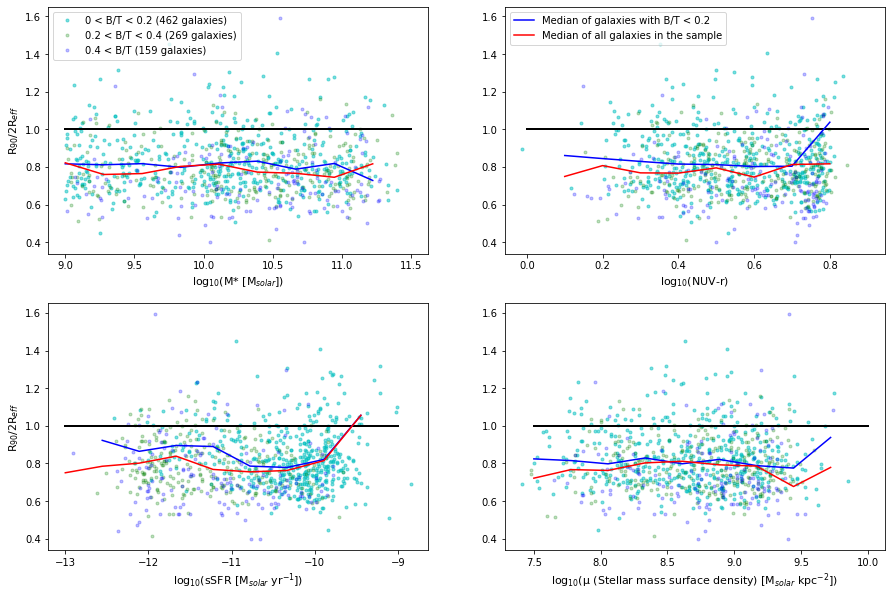

In [ ]:
plt.figure(figsize = (15,10))
zliney = np.ones(10)

# Plotting R90/2Reff against Stellar Mass
plt.subplot(221)
plt.plot(lgMstar_0, Rratio_0, 'c.', alpha = 0.5, label='0 < B/T < 0.2 (462 galaxies)')
plt.plot(lgMstar_02, Rratio_02, 'g.', alpha = 0.25, label='0.2 < B/T < 0.4 (269 galaxies)')
plt.plot(lgMstar_03, Rratio_03, 'b.', alpha = 0.25, label='0.4 < B/T (159 galaxies)')
plt.ylabel('R$_{90}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(M* [M$_{solar}$])', fontsize=11)
# Adding a line where R90 = 2Reff, above here R90 > 2Reff, below 2Reff > R90
zlinex = np.linspace(9, 11.5, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)
# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_Mstar[:-1], median_Mstar[:-1], 'b-')
# Adding a median line for all data
plt.plot(bins_Mstar[:-1], median_Mstar_gl[:-1], 'r-')
plt.legend(loc='upper left')

# Plotting R90/2Reff against NUV-r colour index
plt.subplot(222)
plt.plot(np.log10(NUVr_0), Rratio_0, 'c.', alpha = 0.5)
plt.plot(np.log10(NUVr_02), Rratio_02, 'g.', alpha = 0.25)
plt.plot(np.log10(NUVr_03), Rratio_03, 'b.', alpha = 0.25)
plt.xlabel('log$_{10}$(NUV-r)', fontsize=11)
zlinex = np.linspace(0, 0.9, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)
# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_NUVr[:-1], median_NUVr[:-1], 'b-', label='Median of galaxies with B/T < 0.2')
# Adding a median line for all data
plt.plot(bins_NUVr[:-1], median_NUVr_gl[:-1], 'r-', label='Median of all galaxies in the sample')
plt.legend(loc='upper left')

# Plotting R90/2Reff against sSFR, specific Star Formation Rate
plt.subplot(223)
plt.plot(lgsSFR_0, Rratio_0, 'c.', alpha = 0.5)
plt.plot(lgsSFR_02, Rratio_02, 'g.', alpha = 0.25)
plt.plot(lgsSFR_03, Rratio_03, 'b.', alpha = 0.25)
plt.ylabel('R$_{90}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
zlinex = np.linspace(-13, -9, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)
# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_sSFR[:-1], median_sSFR[:-1], 'b-')
# Adding a median line for all data
plt.plot(bins_sSFR[:-1], median_sSFR_gl[:-1], 'r-')


# Plotting R90/2Reff against stellar mass surface density
plt.subplot(224)
plt.plot(lgmust_0, Rratio_0, 'c.', alpha = 0.5)
plt.plot(lgmust_02, Rratio_02, 'g.', alpha = 0.25)
plt.plot(lgmust_03, Rratio_03, 'b.', alpha = 0.25)
plt.xlabel('log$_{10}$(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
zlinex = np.linspace(7.5, 10, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)
# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_Must[:-1], median_Must[:-1], 'b-')
# Adding a median line for all data
plt.plot(bins_Must[:-1], median_Must_gl[:-1], 'r-');

12) Investigating the bulge dependence of 2x the radius of 50% of the galaxy flux in the r-band

In [ ]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  median_Mstar[i] = np.median(Rratio50_0[np.where((lgMstar_0 >= bins_Mstar[i]) & (lgMstar_0 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  median_NUVr[i] = np.median(Rratio50_0[np.where((np.log10(NUVr_0) >= bins_NUVr[i]) & (np.log10(NUVr_0) <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  median_sSFR[i] = np.median(Rratio50_0[np.where((lgsSFR_0 >= bins_sSFR[i]) & (lgsSFR_0 <= bins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  median_Must[i] = np.median(Rratio50_0[np.where((lgmust_0 >= bins_Must[i]) & (lgmust_0 <= bins_Must[i+1]))])

# Finding a median line for all the data present (global)
# Array of zeroes to store the median of each bin
median_Mstar_gl = np.zeros(len(bins_Mstar))
median_NUVr_gl = np.zeros(len(bins_NUVr))
median_sSFR_gl = np.zeros(len(bins_sSFR))
median_Must_gl = np.zeros(len(bins_Must))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  median_Mstar_gl[i] = np.median(Rratio50[np.where((lgMstar_cut >= bins_Mstar[i]) & (lgMstar_cut <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  median_NUVr_gl[i] = np.median(Rratio50[np.where((np.log10(NUVr_cut) >= bins_NUVr[i]) & (np.log10(NUVr_cut) <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  median_sSFR_gl[i] = np.median(Rratio50[np.where((lgsSFR >= bins_sSFR[i]) & (lgsSFR <= bins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  median_Must_gl[i] = np.median(Rratio50[np.where((lgmust_cut >= bins_Must[i]) & (lgmust_cut <= bins_Must[i+1]))])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


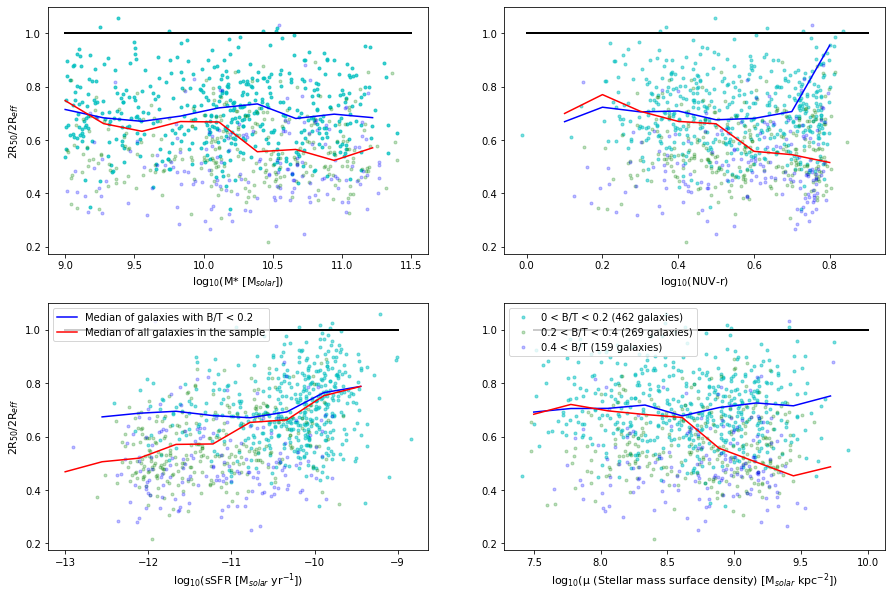

In [ ]:
plt.figure(figsize = (15,10))
zliney = np.ones(10)

# Plotting 2R50/2Reff against Stellar Mass
plt.subplot(221)
plt.plot(lgMstar_0, Rratio50_0, 'c.', alpha = 0.75)
plt.plot(lgMstar_02, Rratio50_02, 'g.', alpha = 0.25)
plt.plot(lgMstar_03, Rratio50_03, 'b.', alpha = 0.25)
plt.ylabel('2R$_{50}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(M* [M$_{solar}$])', fontsize=11)
# Adding a line where 2R50 = 2Reff, above here 2R50 > 2Reff, below 2Reff > 2R50
zlinex = np.linspace(9, 11.5, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)

# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_Mstar[:-1], median_Mstar[:-1], 'b-')
# Adding a median line for all data
plt.plot(bins_Mstar[:-1], median_Mstar_gl[:-1], 'r-')

# Plotting 2R50/2Reff against NUV-r colour index
plt.subplot(222)
plt.plot(np.log10(NUVr_0), Rratio50_0, 'c.', alpha = 0.5)
plt.plot(np.log10(NUVr_02), Rratio50_02, 'g.', alpha = 0.25)
plt.plot(np.log10(NUVr_03), Rratio50_03, 'b.', alpha = 0.25)
plt.xlabel('log$_{10}$(NUV-r)', fontsize=11)
zlinex = np.linspace(0, 0.9, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)

# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_NUVr[:-1], median_NUVr[:-1], 'b-')
# Adding a median line for all data
plt.plot(bins_NUVr[:-1], median_NUVr_gl[:-1], 'r-')

# Plotting 2R50/2Reff against sSFR, specific Star Formation Rate
plt.subplot(223)
plt.plot(lgsSFR_0, Rratio50_0, 'c.', alpha = 0.5)
plt.plot(lgsSFR_02, Rratio50_02, 'g.', alpha = 0.25)
plt.plot(lgsSFR_03, Rratio50_03, 'b.', alpha = 0.25)
plt.ylabel('2R$_{50}$/2R$_{eff}$', fontsize=11)
plt.xlabel('log$_{10}$(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
zlinex = np.linspace(-13, -9, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)

# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_sSFR[:-1], median_sSFR[:-1], 'b-', label='Median of galaxies with B/T < 0.2')
# Adding a median line for all data
plt.plot(bins_sSFR[:-1], median_sSFR_gl[:-1], 'r-', label='Median of all galaxies in the sample')
plt.legend(loc='upper left');

# Plotting 2R50/2Reff against stellar mass surface density
plt.subplot(224)
plt.plot(lgmust_0, Rratio50_0, 'c.', alpha = 0.5, label='0 < B/T < 0.2 (462 galaxies)')
plt.plot(lgmust_02, Rratio50_02, 'g.', alpha = 0.25, label='0.2 < B/T < 0.4 (269 galaxies)')
plt.plot(lgmust_03, Rratio50_03, 'b.', alpha = 0.25, label='0.4 < B/T (159 galaxies)')
plt.xlabel('log$_{10}$(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
zlinex = np.linspace(7.5, 10, 10)
plt.plot(zlinex, zliney, 'k-', linewidth = 2)

# Adding a median line for 0 < B/T < 0.2
plt.plot(bins_Must[:-1], median_Must[:-1], 'b-')
# Adding a median line for all data
plt.plot(bins_Must[:-1], median_Must_gl[:-1], 'r-')
plt.legend(loc='upper left');


13) Writing an ascii output file for various data found in the above code

In [ ]:
np.savetxt('xGASS_HI_masses.txt', np.c_[GASS, lgMHI, lgMHIpredin2eff, lgMHIpredinr90, HIsrc, Rkpc, effRkpc], header='GASSID lgMHI_global  lgMHI_2Reff lgMHI_r90 HIsource  r90_kpc 2Reff_kpc',fmt='%s', delimiter='\t')